In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Dataset: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [2]:
boston_data = load_boston()

In [3]:
X = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
y = boston_data['target']

Для начала нужно разбить выборку на обучающую и тестовую.

Качество модели нужно оценивать по выборке, которая не участвовала в обучении.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, test_size=0.3, random_state=123)

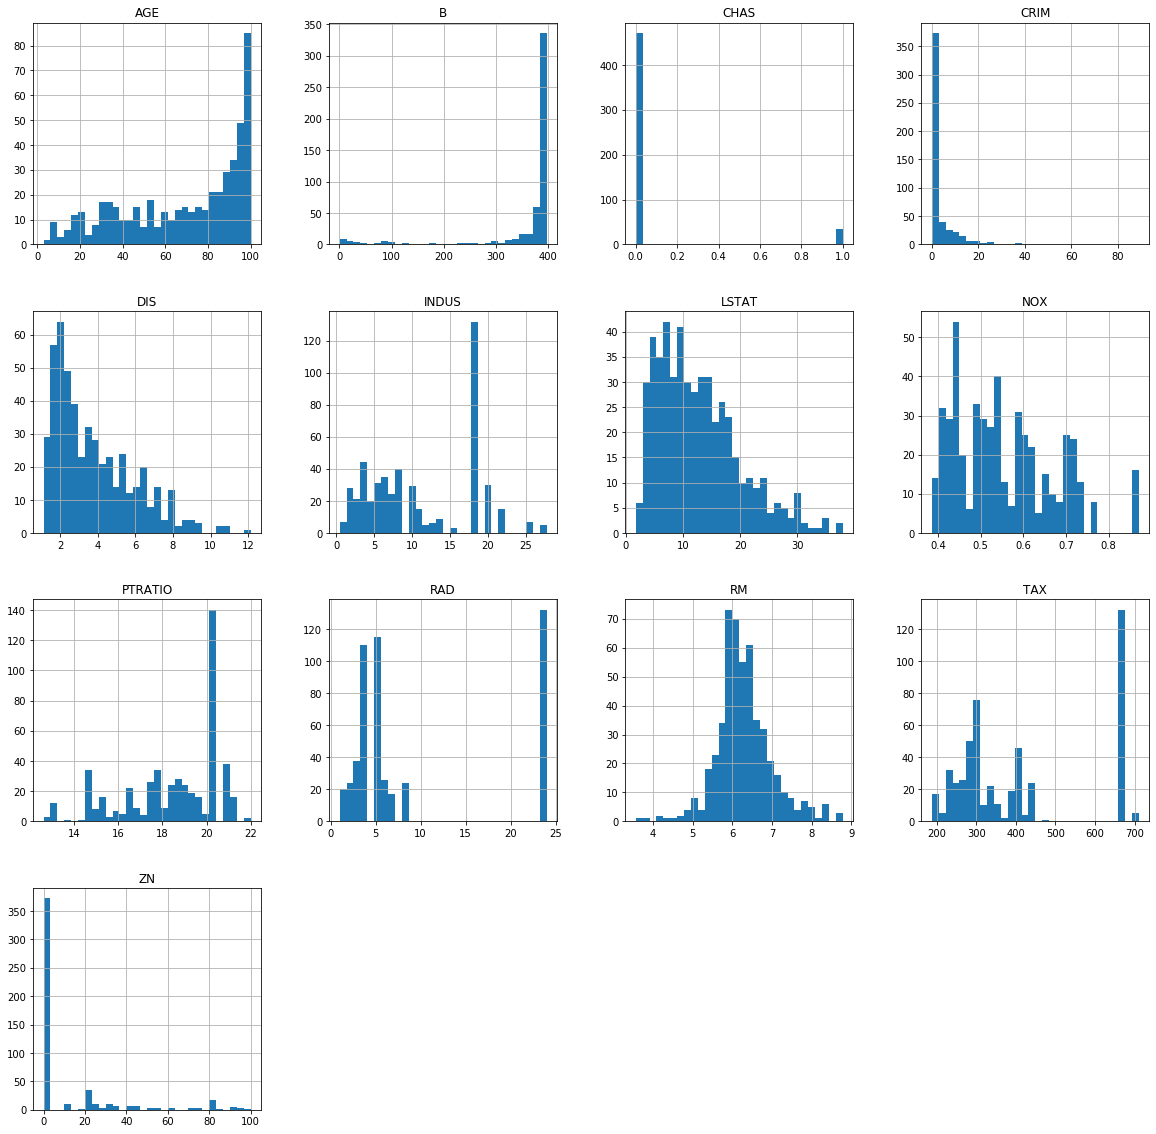

In [5]:
_ = X.hist(X.columns, bins=30, figsize=(20, 20))

Линейные модели очень чувствительны к нормировке данных

Давайте отнормируем признаки

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[:] = scaler.fit_transform(X_train)
X_test[:] = scaler.transform(X_test)

In [7]:
X[:] = scaler.fit_transform(X)

###  Обучим линейную регрессию

In [8]:
lr = LinearRegression()

In [9]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [10]:
print("MSE error:\t{}".format(mse(y_test, y_pred)))

MSE error:	28.405854810508238


### Построим модель, предсказывающую log(y)

Почему это может сработать?
Линейные модели хорошо улавливают линейные зависимости. Но в реальной жизни связи с таргетом могут быть нелинейны. Если есть знание о том, как лучше всего "выпрямить" признак или целевую переменную, то можно попробовать это сделать.
В данном случае стоимость квартиры может быть менее линейно связана с признаками, чем порядок (log) этой стоимости.


Возьмем один признак LSTAT и только на нем обучим модель предсказывать сначала y, а затем log(y)

Text(0, 0.5, 'Target')

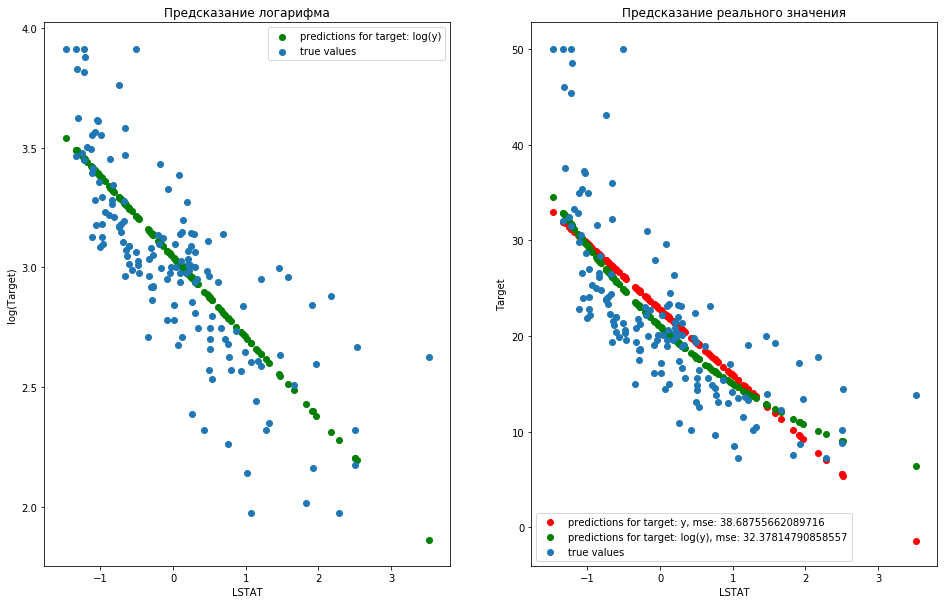

In [11]:
column = 'LSTAT'

lr.fit(X_train[[column]], y_train)
y_pred = lr.predict(X_test[[column]])
y_error = mse(y_test, y_pred)

lr.fit(X_train[[column]], np.log(y_train))
y_log_pred = np.exp(lr.predict(X_test[[column]]))
y_log_error = mse(y_test, y_log_pred)

f, arr = plt.subplots(ncols=2, figsize=(16, 10))
for i in range(2):
    if i != 0:
        arr[i].scatter(X_test[column], np.log(y_pred) if i == 0 else y_pred, c='r')
    arr[i].scatter(X_test[column], np.log(y_log_pred) if i == 0 else y_log_pred, c='g')
    arr[i].scatter(X_test[column], np.log(y_test) if i == 0 else y_test)


    arr[i].set_xlabel(column)
    
arr[0].set_title(u"Предсказание логарифма")
arr[1].set_title(u"Предсказание реального значения")

arr[0].legend(['predictions for target: log(y)', 'true values'])

arr[1].legend(['predictions for target: y, mse: {}'.format(y_error),
               'predictions for target: log(y), mse: {}'.format(y_log_error),
               'true values'])
arr[0].set_ylabel("log(Target)")
arr[1].set_ylabel("Target")


Видно, что переходя к предсказанию порядка величины, модель лучше описывает целевую переменную

Теперь на всех факторах

In [12]:
lr.fit(X_train, np.log(y_train))
y_pred = np.exp(lr.predict(X_test))

In [13]:
print("MSE error:\t{}".format(mse(y_test, y_pred)))

MSE error:	22.28602591973571


get_cv_score (реализована ниже) - считает ошибку модели на кросс валидации, опционально может прологарифмировать таргет.
Также может служить примером работы с классом [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
Похожий функционал реализован в функции [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [14]:
from sklearn.model_selection import KFold


def get_cv_score(model, X, y, log_y):
    errors = []
    kf = KFold(n_splits=100, shuffle=True, random_state=123)
    for train_index, test_index in kf.split(X):
        X_train, y_train =  X.iloc[train_index], y[train_index]
        X_test, y_test = X.iloc[test_index], y[test_index]

        if log_y:
            model.fit(X_train, np.log(y_train))
            y_pred = np.exp(model.predict(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        errors.append(mse(y_test, y_pred))
    return np.mean(errors)

In [15]:
print(get_cv_score(lr, X, y, log_y=True))
print(get_cv_score(lr, X, y, log_y=False))

19.475015360715588
23.448545939673085


### Посчитаем логарифмы для факторов

Логарифмирование факторов часто помогает, если по своей природе фактор - некоторый счетчик (либо если есть иные причины полагать, что порядок величины и целевая переменная линейно скоррелированы)

In [16]:
scaler.inverse_transform(X).min()

0.0

In [17]:
scaler_for_log = StandardScaler()

log_X = pd.DataFrame(np.log(1. + scaler.inverse_transform(X)), columns=["log_" + col for col in X.columns])
log_X[:] = scaler_for_log.fit_transform(log_X)

Ошибка модели на исходных факторах

In [18]:
get_cv_score(lr, X, y, log_y=True)

19.475015360715588

Ошибка модели на логарифмических факторах

In [19]:
get_cv_score(lr, log_X, y, log_y=True)

18.279862789286422

Ошибка модели на исходных + логарифмических факторах

In [20]:
X_all = pd.merge(X, log_X, left_index=True, right_index=True)
get_cv_score(lr, X_all, y, log_y=True)

16.052598858538488

Ошибка уменьшается. Таким образом, для линейной модели важно, насколько "линейными" являются данные на входе. Если есть знания о природе факторов и целевой переменной, можно попытаться нелинейными преобразованиями этих величин добиться улучшения качества линейной модели.

Важность факторов (коэффициенты линейной модели)

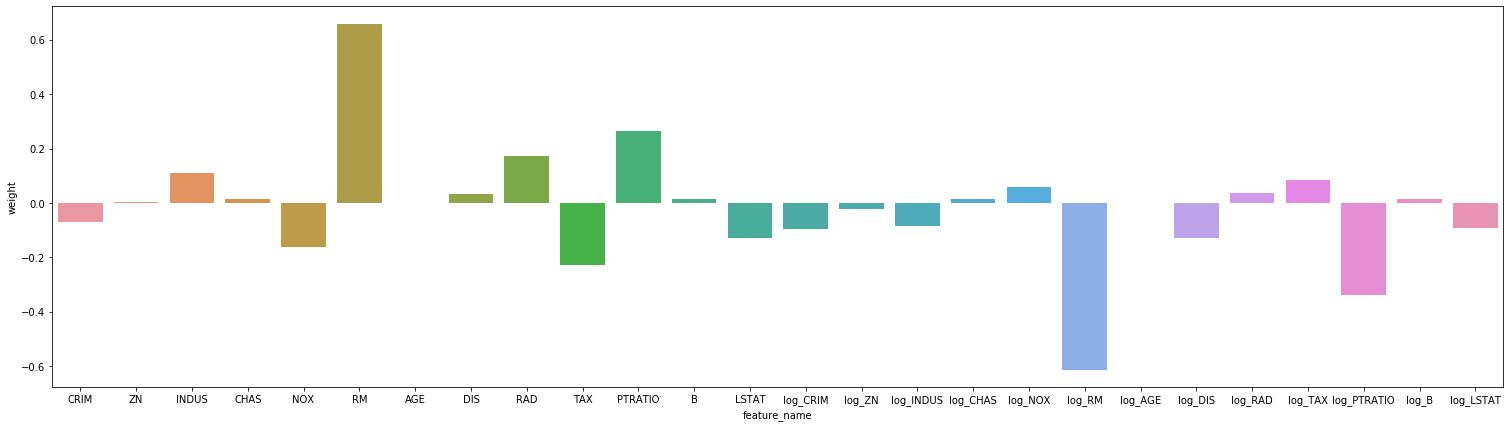

In [21]:
def plot_bar(coefs, names):
    assert coefs.shape[0] == len(names)
    weights_df = pd.DataFrame(zip(coefs, names),
                              columns=['weight', 'feature_name'])
    fig, ax = plt.subplots(figsize=(weights_df.shape[0] * 1, 7))
    sns.barplot(ax=ax, x="feature_name", y="weight", data=weights_df)
    return weights_df

weights_df = plot_bar(lr.coef_, X_all.columns)

### Будем добавлять факторы, начиная с самых больших по весу

In [22]:
weights_df['abs_weight'] = weights_df['weight'].abs()
weights_df.sort_values(by=['abs_weight'], ascending=False, inplace=True)

In [23]:
mse_errors = []
for i in range(1, weights_df.shape[0]):
    features_subset = weights_df.iloc[:i]['feature_name']
    mse_errors.append(get_cv_score(LinearRegression(), X_all[features_subset], y, log_y=True))
    

Text(0, 0.5, 'MSE')

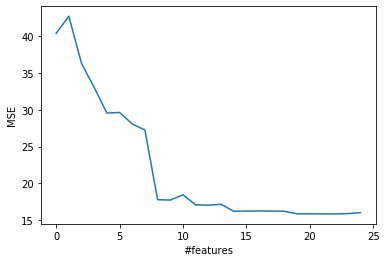

In [24]:
plt.plot(mse_errors)
plt.xlabel('#features')
plt.ylabel('MSE')

### Регуляризация

In [25]:
from sklearn.linear_model import Lasso, Ridge

In [26]:
def fit_and_plot_coef(model, X, y):
    # in fact weights are adjusted by the last iteration of cv
    print("Model quality:\t{}".format(get_cv_score(model, X, y, log_y=True)))

    plot_bar(model.coef_, X.columns)
    print("Sum of coefficients:\t{}".format(np.abs(model.coef_).sum()))
    print("# of nonzero coefficients:\t{} / {}".format(np.count_nonzero(~np.isclose(model.coef_, 0)), model.coef_.shape[0]))

### L2 регуляризация (alpha=1)

Model quality:	19.483533969727482
Sum of coefficients:	0.9628712327172632
# of nonzero coefficients:	13 / 13


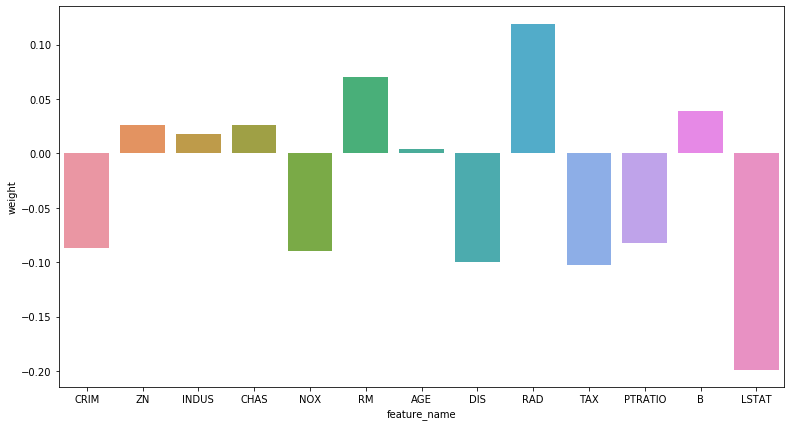

In [27]:
ridge = Ridge(alpha=1)
fit_and_plot_coef(ridge, X, y)

###  L2 регуляризация (alpha=100)

Model quality:	22.37601001157377
Sum of coefficients:	0.6243798703387493
# of nonzero coefficients:	13 / 13


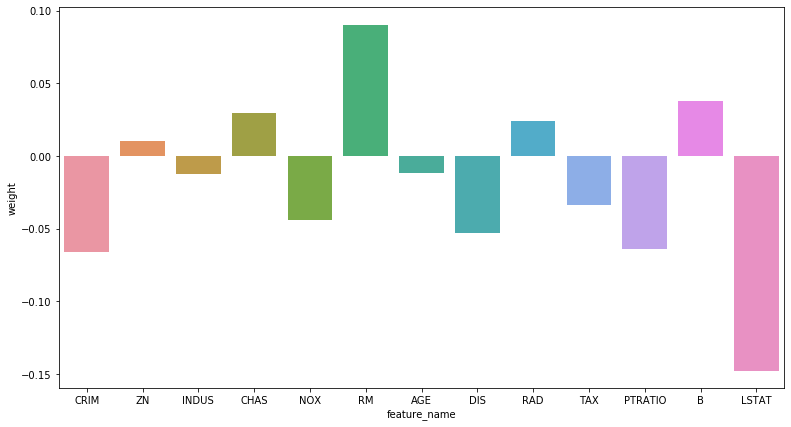

In [28]:
ridge = Ridge(alpha=100)
fit_and_plot_coef(ridge, X, y)

Модули весов уменьшаются

### L1 регуляризация (alpha=0.01)

Model quality:	21.69982755081639
Sum of coefficients:	0.5484933182202518
# of nonzero coefficients:	9 / 13


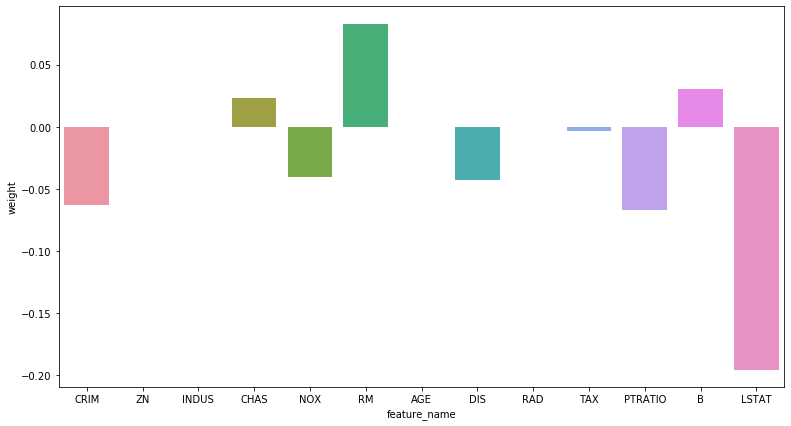

In [29]:
lasso = Lasso(alpha=0.01)
fit_and_plot_coef(lasso, X, y)

### L1 регуляризация (alpha=0.1)

Model quality:	38.54047402783083
Sum of coefficients:	0.2576352943756148
# of nonzero coefficients:	4 / 13


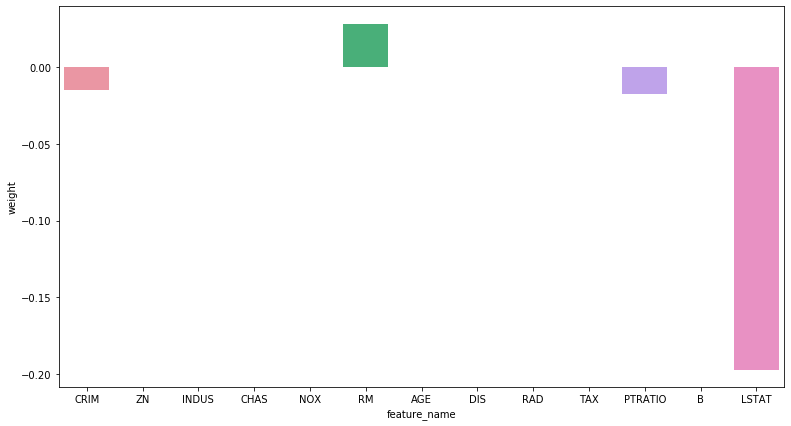

In [30]:
lasso = Lasso(alpha=0.1)
fit_and_plot_coef(lasso, X, y)

Количество ненулевых коэффициентов уменьшается

### Добавим линейно-зависимый фактор

In [31]:
X_lin_dep = X.copy()
X_lin_dep['TAX_B'] = X_lin_dep['TAX']  + X_lin_dep['B'] + np.random.rand(X.shape[0]) / 100

In [32]:
X_lin_dep.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TAX_B
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,-0.220424
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.540240
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,-0.582349
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,-0.689919
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,-0.663627


Сначала обучимся без регуляризатора

Model quality:	19.537197723782604
Sum of coefficients:	4.780604267198239
# of nonzero coefficients:	14 / 14


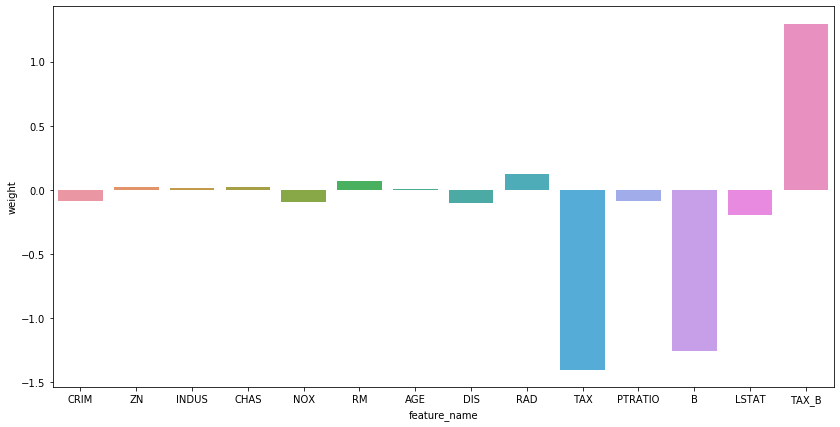

In [33]:
ridge = Ridge(alpha=0)
fit_and_plot_coef(ridge, X_lin_dep, y)

Видно, как наша модель уловила связь между факторами <i>TAB</i>, <i>B</i> и <i>TAX_B</i>: 

$ C_{TAX} + C_B + C_{TAX\_B} = 0 $

Добавим регуляризатор

Model quality:	19.48550295615587
Sum of coefficients:	0.9831643767712807
# of nonzero coefficients:	14 / 14


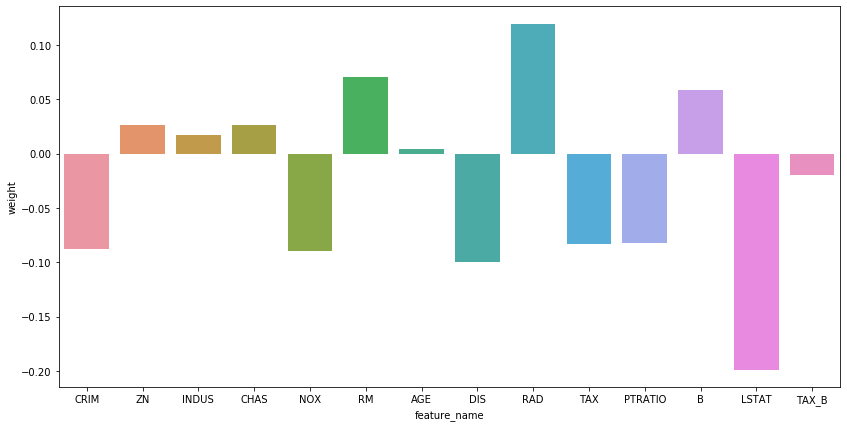

In [34]:
ridge = Ridge(alpha=1)
fit_and_plot_coef(ridge, X_lin_dep, y)

Веса рассматриваемых факторов уменьшились по модулю. Попробуем L1 регуляризатор.

Model quality:	19.578749996602753
Sum of coefficients:	0.9028813266968108
# of nonzero coefficients:	13 / 14


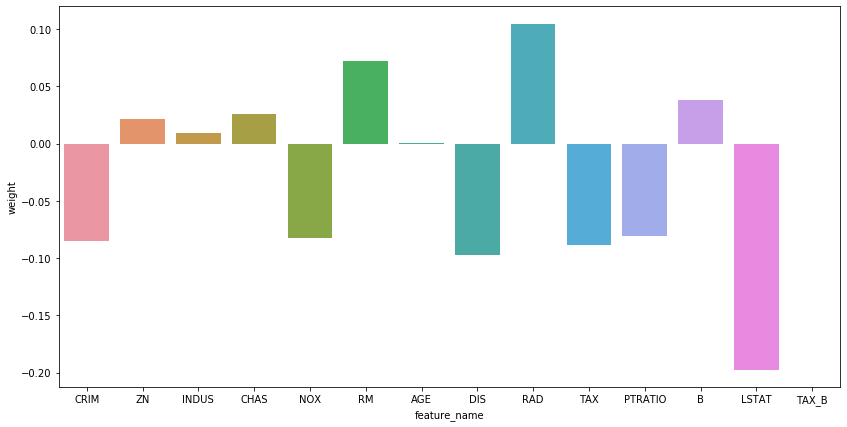

In [35]:
lasso = Lasso(alpha=1e-3)
fit_and_plot_coef(lasso, X_lin_dep, y)

Фиктивный фактор сразу же исчез

### Logistic Regression

In [36]:
y = (y < np.median(y)).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [38]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
y_pred = log_reg.predict(X_test)
y_pred

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1])

### Предскажем метку класса

In [40]:
log_loss(y_test, y_pred)

5.680740843832157

### Предсказание рандомом

In [41]:
log_loss(y_test, np.random.choice([0, 1], size=y_test.shape[0]))

15.224481623582179

### Предскажем вероятность

In [42]:
y_pred = log_reg.predict_proba(X_test)[:, 1]
log_loss(y_test, y_pred)

0.29889880622014475

### Decision function -  < w, x >

In [43]:
y_dec_pred = 1. / (1 + np.exp(-log_reg.decision_function(X_test)))

In [44]:
log_loss(y_test, y_dec_pred)

0.29889880622014475

### Margin

In [45]:
y_test_rescaled = (y_test - 0.5) * 2

In [46]:
m = log_reg.decision_function(X_test) * y_test_rescaled

In [47]:
m.sort()

Text(0, 0.5, 'Margin')

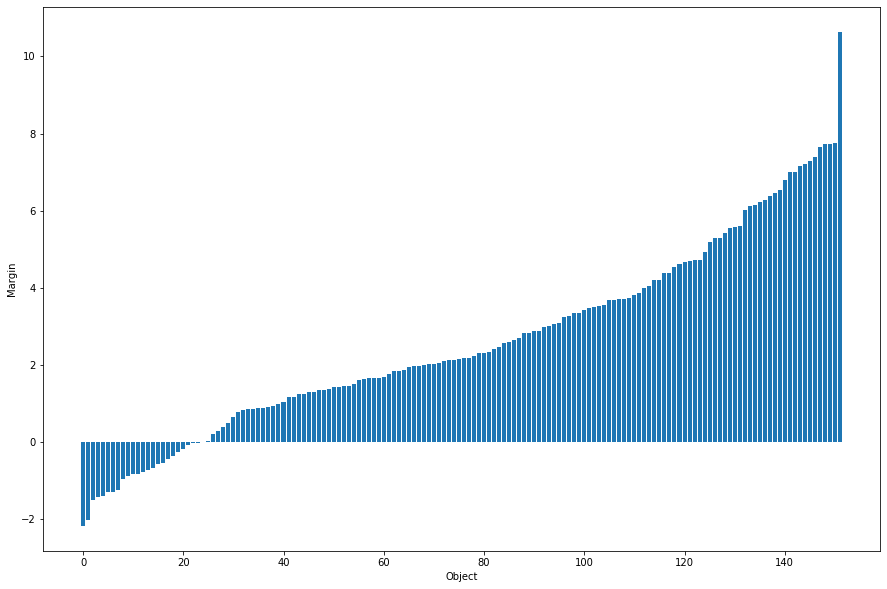

In [48]:
plt.figure(figsize=(15, 10))
plt.bar(range(m.shape[0]), m)
plt.xlabel('Object')
plt.ylabel('Margin')